Class Names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


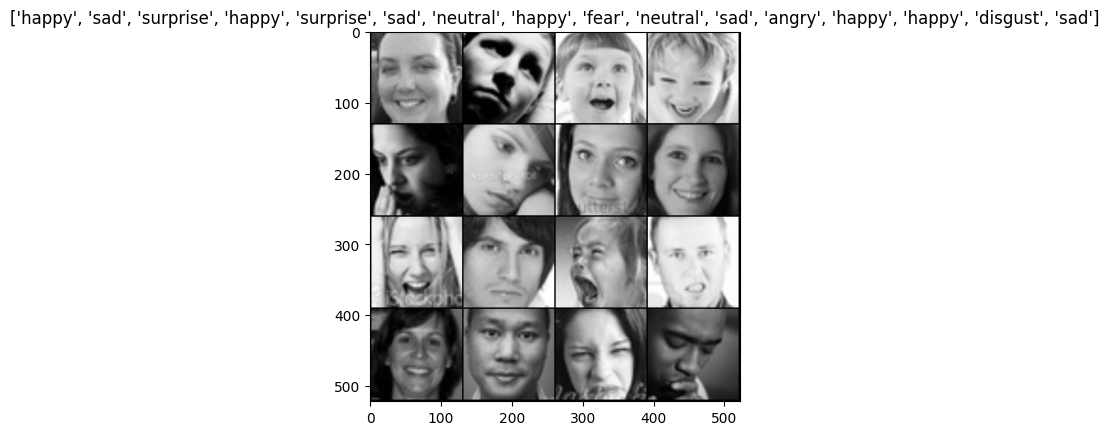

Image Dimensions: torch.Size([16, 3, 128, 128])


In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
import random

random.seed(42)


# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing all images to 128x128
    transforms.ToTensor(),          # Convert images to tensors
])

# Load the dataset
dataset = datasets.ImageFolder(root='emotions', transform=transform)
subset_size = int(0.2 * len(dataset))
indices = random.sample(range(len(dataset)), subset_size)
subset = Subset(dataset, indices)



# Display class names
class_names = dataset.classes
print("Class Names:", class_names)

# Create a DataLoader to iterate over the dataset
data_loader = torch.utils.data.DataLoader(subset, batch_size=16, shuffle=True)

# Function to show images in a grid
def show_images(images, labels):
    images = make_grid(images, nrow=4)
    npimg = images.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title([class_names[label] for label in labels])
    plt.show()

# Get a batch of images and labels
images, labels = next(iter(data_loader))

# Show images and labels
show_images(images, labels)

# Print the dimensions of the images
print("Image Dimensions:", images.shape)  # Should be (Batch Size, Channels, Height, Width)


In [2]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
num_classes = len(class_names)
model = SimpleCNN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Use TQDM for progress tracking
    for images, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training Complete!")

torch.save(model.state_dict(), 'classifier_cnn_model.pt')

Epoch 1/10: 100%|██████████| 361/361 [00:11<00:00, 30.89it/s]


Epoch [1/10], Loss: 1.8517, Accuracy: 25.95%


Epoch 2/10: 100%|██████████| 361/361 [00:11<00:00, 31.87it/s]


Epoch [2/10], Loss: 1.6930, Accuracy: 32.39%


Epoch 3/10: 100%|██████████| 361/361 [00:11<00:00, 31.65it/s]


Epoch [3/10], Loss: 1.6044, Accuracy: 37.21%


Epoch 4/10: 100%|██████████| 361/361 [00:11<00:00, 30.29it/s]


Epoch [4/10], Loss: 1.4716, Accuracy: 43.08%


Epoch 5/10: 100%|██████████| 361/361 [00:11<00:00, 31.56it/s]


Epoch [5/10], Loss: 1.2764, Accuracy: 51.35%


Epoch 6/10: 100%|██████████| 361/361 [00:12<00:00, 30.08it/s]


Epoch [6/10], Loss: 0.9791, Accuracy: 64.42%


Epoch 7/10: 100%|██████████| 361/361 [00:11<00:00, 30.40it/s]


Epoch [7/10], Loss: 0.5854, Accuracy: 79.63%


Epoch 8/10: 100%|██████████| 361/361 [00:11<00:00, 31.04it/s]


Epoch [8/10], Loss: 0.2734, Accuracy: 91.67%


Epoch 9/10: 100%|██████████| 361/361 [00:11<00:00, 30.91it/s]


Epoch [9/10], Loss: 0.1219, Accuracy: 96.70%


Epoch 10/10: 100%|██████████| 361/361 [00:11<00:00, 30.69it/s]


Epoch [10/10], Loss: 0.0458, Accuracy: 99.01%
Training Complete!


Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.98      0.99       783
     disgust       1.00      0.97      0.98        86
        fear       0.99      0.99      0.99       780
       happy       1.00      0.99      0.99      1452
     neutral       0.99      0.99      0.99       966
         sad       0.99      1.00      0.99      1064
    surprise       0.99      1.00      0.99       633

    accuracy                           0.99      5764
   macro avg       0.99      0.99      0.99      5764
weighted avg       0.99      0.99      0.99      5764



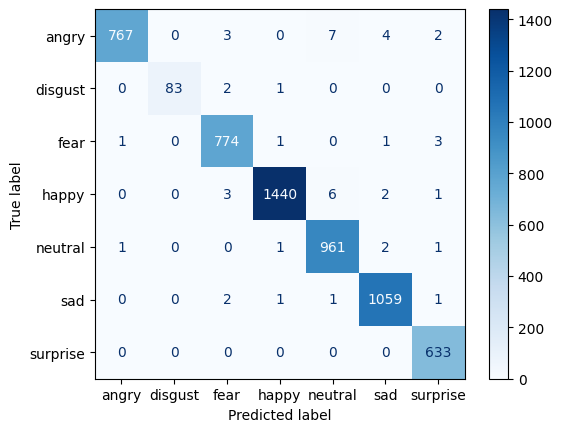

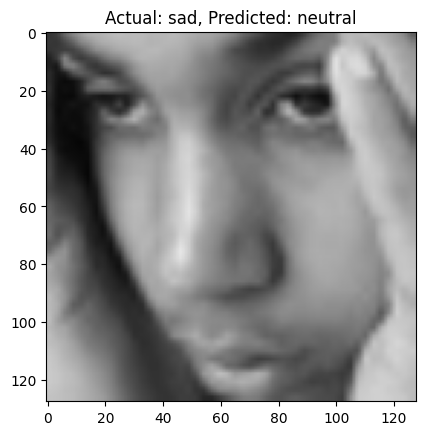

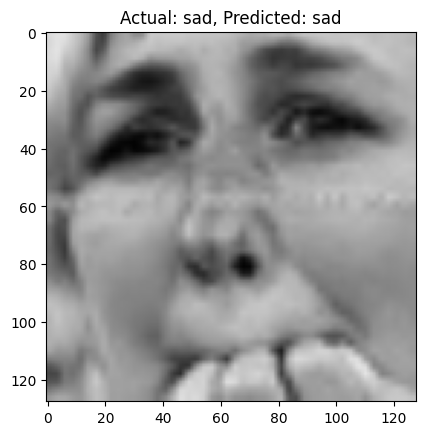

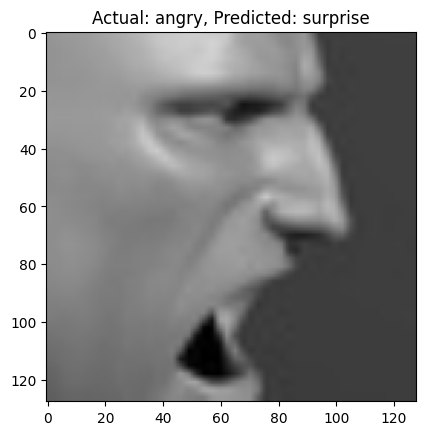

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random

def test_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    indices = random.sample(range(len(dataset)), 3)
    for i in indices:
        image, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_label = predicted.item()
        plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Actual: {class_names[label]}, Predicted: {class_names[predicted_label]}")
        plt.show()

test_model(model, data_loader)


In [4]:
'''import torch
import torch.nn.functional as F
import numpy as np
from scipy.optimize import differential_evolution
from tqdm import tqdm

def one_pixel_attack(image, label, model, bounds, maxiter=20):
    def perturb_pixel(pixel):
        perturbed_image = image.clone()
        perturbed_image[0, :, int(pixel[0]), int(pixel[1])] = torch.tensor(pixel[2:], device=image.device)
        with torch.no_grad():
            output = model(perturbed_image)
        loss = -F.cross_entropy(output, torch.tensor([label], device=image.device))
        return loss.item()
    
    result = differential_evolution(perturb_pixel, bounds=bounds, maxiter=maxiter, popsize=10)
    return result.x

bounds = [(0, 127), (0, 127), (0, 1), (0, 1), (0, 1)]  

model.eval()

dog_breeds_attacked = []
patch_data = []

batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

for batch_idx, (images, labels) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Attacking images"):
    images = images.to(device)
    labels = labels.to(device)
    
    for i in range(images.size(0)):
        image = images[i].unsqueeze(0)
        label = labels[i]
        
        pixel = one_pixel_attack(image, label, model, bounds)
        attacked_image = image.clone()
        attacked_image[0, :, int(pixel[0]), int(pixel[1])] = torch.tensor(pixel[2:], device=image.device)
        
        dog_breeds_attacked.append((attacked_image.cpu().squeeze(), label.item()))
        
        patch_size = 16
        for row in range(0, 128, patch_size):
            for col in range(0, 128, patch_size):
                patch = attacked_image[:, :, row:row+patch_size, col:col+patch_size]
                patch_id = f"[{batch_idx * batch_size + i}][{row//patch_size * 8 + col//patch_size}]"
                attacked_or_not = 1 if (row <= pixel[0] < row + patch_size and col <= pixel[1] < col + patch_size) else 0
                patch_data.append((patch.cpu().squeeze(), patch_id, attacked_or_not))

    if (batch_idx + 1) % 10 == 0:
        torch.save(dog_breeds_attacked, f'animals-attacked-{batch_idx+1}.pt')
        torch.save(patch_data, f'Patch-data-{batch_idx+1}.pt')
        dog_breeds_attacked = []
        patch_data = []

# Save any remaining data
if dog_breeds_attacked:
    torch.save(dog_breeds_attacked, f'animals-attacked.pt')
if patch_data:
    torch.save(patch_data, f'Patch-data.pt')'''

'import torch\nimport torch.nn.functional as F\nimport numpy as np\nfrom scipy.optimize import differential_evolution\nfrom tqdm import tqdm\n\ndef one_pixel_attack(image, label, model, bounds, maxiter=20):\n    def perturb_pixel(pixel):\n        perturbed_image = image.clone()\n        perturbed_image[0, :, int(pixel[0]), int(pixel[1])] = torch.tensor(pixel[2:], device=image.device)\n        with torch.no_grad():\n            output = model(perturbed_image)\n        loss = -F.cross_entropy(output, torch.tensor([label], device=image.device))\n        return loss.item()\n    \n    result = differential_evolution(perturb_pixel, bounds=bounds, maxiter=maxiter, popsize=10)\n    return result.x\n\nbounds = [(0, 127), (0, 127), (0, 1), (0, 1), (0, 1)]  \n\nmodel.eval()\n\ndog_breeds_attacked = []\npatch_data = []\n\nbatch_size = 32\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)\n\nfor batch_idx, (images, labels) in tqdm(enumerate(dataloader), total=l

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.optimize import differential_evolution
from tqdm import tqdm

def one_pixel_attack(image, label, model, bounds, maxiter=20):
    def perturb_pixel(pixel):
        perturbed_image = image.clone()
        perturbed_image[0, :, int(pixel[0]), int(pixel[1])] = torch.tensor(pixel[2:], device=image.device)
        with torch.no_grad():
            output = model(perturbed_image)
        loss = -F.cross_entropy(output, torch.tensor([label], device=image.device))
        return loss.item()
    
    result = differential_evolution(perturb_pixel, bounds=bounds, maxiter=maxiter, popsize=10)
    return result.x

bounds = [(0, 127), (0, 127), (0, 1), (0, 1), (0, 1)]  

model.eval()

dog_breeds_attacked = []
patch_data = []

batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

for batch_idx, (images, labels) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Attacking images"):
    images = images.to(device)
    labels = labels.to(device)
    
    for i in range(images.size(0)):
        image = images[i].unsqueeze(0)
        label = labels[i]
        
        pixel = one_pixel_attack(image, label, model, bounds)
        attacked_image = image.clone()
        attacked_image[0, :, int(pixel[0]), int(pixel[1])] = torch.tensor(pixel[2:], device=image.device)
        
        dog_breeds_attacked.append((attacked_image.cpu().squeeze(), label.item()))
        
        patch_size = 16
        for row in range(0, 128, patch_size):
            for col in range(0, 128, patch_size):
                patch = attacked_image[:, :, row:row+patch_size, col:col+patch_size]
                patch_id = f"[{batch_idx * batch_size + i}][{row//patch_size * 8 + col//patch_size}]"
                attacked_or_not = 1 if (row <= pixel[0] < row + patch_size and col <= pixel[1] < col + patch_size) else 0
                patch_data.append((patch.cpu().squeeze(), patch_id, attacked_or_not))

# Save the complete datasets
torch.save(dog_breeds_attacked, 'animals-attacked.pt')
torch.save(patch_data, 'Patch-data.pt')


Attacking images: 100%|██████████| 901/901 [8:19:47<00:00, 33.28s/it]  


In [6]:
import torch

# Load the datasets
dog_breeds_attacked = torch.load('animals-attacked.pt')
patch_data = torch.load('Patch-data.pt')
dataset = datasets.ImageFolder(root='dog-breeds', transform=transform)

# Get the number of samples
num_attacked_samples = len(dog_breeds_attacked)
num_patch_samples = len(patch_data)
num_originl_samples = len(dataset)

print(f'Total number of samples in animals-attacked.pt: {num_attacked_samples}')
print(f'Total number of samples in Patch-data.pt: {num_patch_samples}')
print(f'Total number of samples in original dataset: {num_originl_samples}')


Total number of samples in animals-attacked.pt: 28821
Total number of samples in Patch-data.pt: 1844544
Total number of samples in original dataset: 967


Testing attacked dataset: 100%|██████████| 28821/28821 [00:45<00:00, 626.72it/s]


Accuracy: 45.89%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.32      0.38      3993
           1       0.72      0.24      0.36       436
           2       0.39      0.35      0.37      4103
           3       0.61      0.52      0.56      7164
           4       0.40      0.45      0.42      4982
           5       0.36      0.49      0.41      4938
           6       0.54      0.62      0.58      3205

    accuracy                           0.46     28821
   macro avg       0.50      0.43      0.44     28821
weighted avg       0.47      0.46      0.46     28821



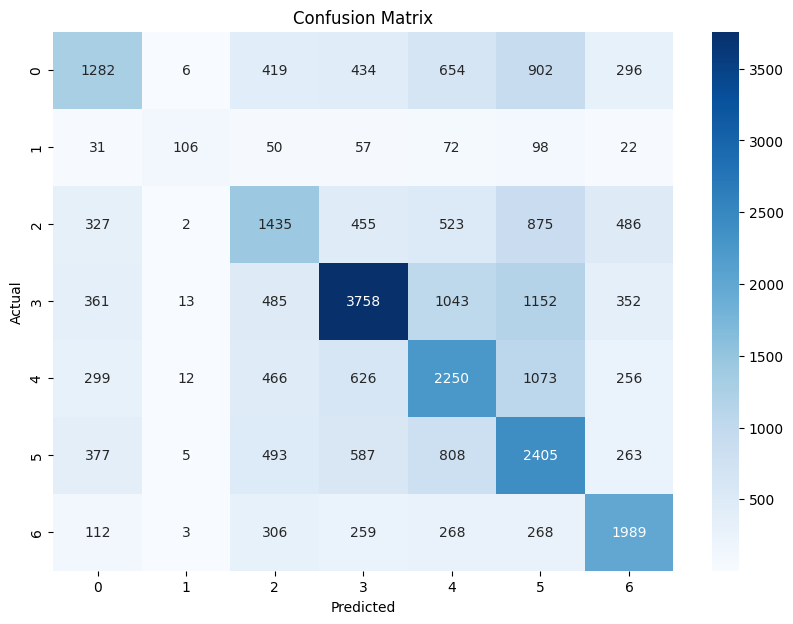

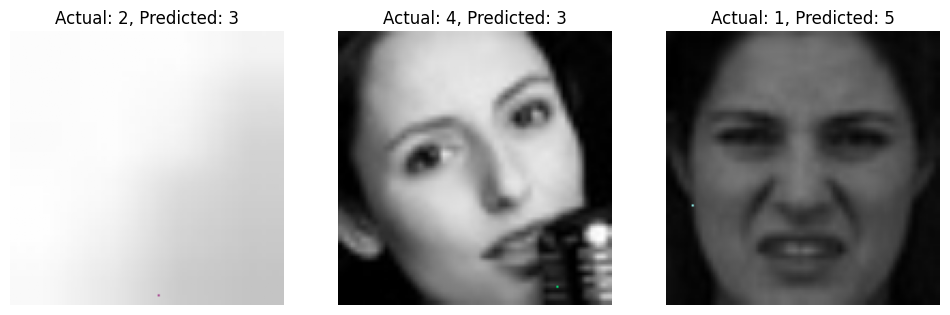

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

dog_breeds_attacked = torch.load('animals-attacked.pt')

model.eval()

all_preds = []
all_labels = []
loss_fn = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for attacked_image, label in tqdm(dog_breeds_attacked, desc="Testing attacked dataset"):
        attacked_image = attacked_image.unsqueeze(0).to(device)  # Add batch dimension
        label = torch.tensor(label).to(device)  # Convert label to tensor
        
        output = model(attacked_image)
        loss = loss_fn(output, label.unsqueeze(0))  # Compute loss
        
        _, predicted = torch.max(output, 1)  # Get predicted class
        
        all_preds.append(predicted.item())
        all_labels.append(label.item())

# Calculate accuracy
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Show actual and predicted classes for 3 random images
random_indices = np.random.choice(len(dog_breeds_attacked), size=3, replace=False)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(random_indices):
    attacked_image, label = dog_breeds_attacked[idx]
    attacked_image = attacked_image.permute(1, 2, 0)  # Rearrange for plotting
    attacked_image = attacked_image.numpy()

    # Get prediction
    predicted = all_preds[idx]
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(attacked_image)
    plt.title(f'Actual: {label}, Predicted: {predicted}')
    plt.axis('off')

plt.show()


Class Label: 0


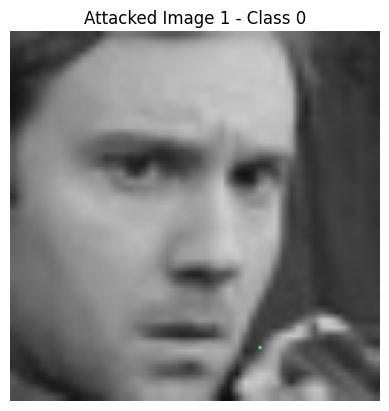

Class Label: 0


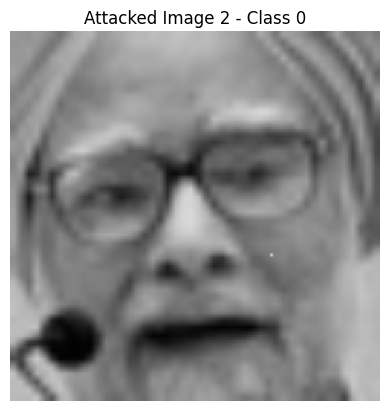

Class Label: 0


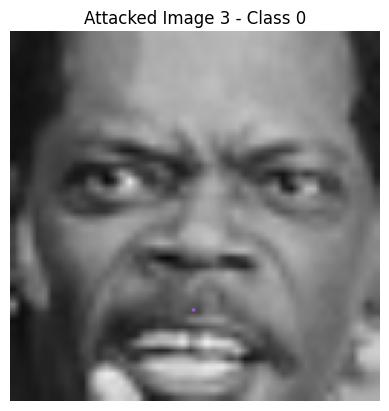

torch.Size([3, 128, 128])

In [8]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

dog_breeds_attacked = torch.load('animals-attacked.pt')

def show_image(image_tensor, title=""):
    image = image_tensor.squeeze(0)  # Remove the batch dimension
    image = transforms.ToPILImage()(image)  # Convert tensor to PIL image
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preview a few images from the attacked dataset
for i in range(3):  # Change the range to see more examples
    attacked_image, label = dog_breeds_attacked[i]
    print(f"Class Label: {label}")
    show_image(attacked_image, title=f"Attacked Image {i+1} - Class {label}")
attacked_image.shape

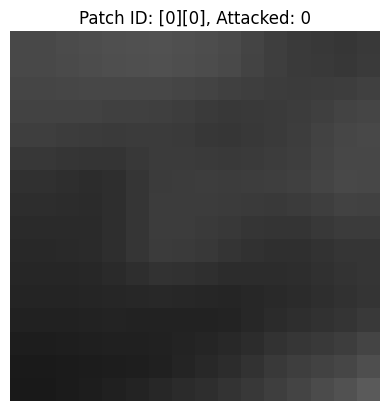

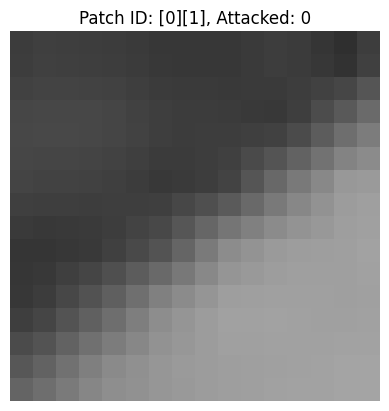

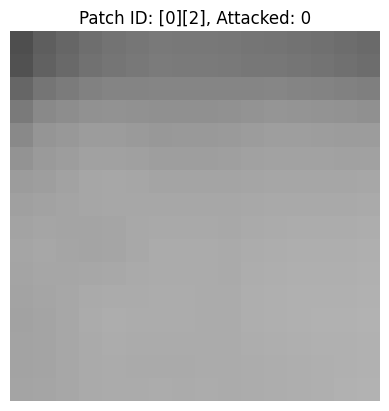

In [9]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the patch dataset
patch_data = torch.load('Patch-data.pt')

# Function to display a patch
def show_patch(patch_tensor, patch_id, attacked_or_not):
    patch = patch_tensor.squeeze(0)  # Remove the batch dimension
    patch = transforms.ToPILImage()(patch)  # Convert tensor to PIL image
    plt.imshow(patch)
    title = f"Patch ID: {patch_id}, Attacked: {attacked_or_not}"
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preview a few patches from the patch dataset
for i in range(3):  # Change the range to see more examples
    patch_tensor, patch_id, attacked_or_not = patch_data[i]
    show_patch(patch_tensor, patch_id, attacked_or_not)
patch_tensor, _, _ = patch_data[0]


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F


# Define the CNN model
class PatchCNN(nn.Module):
    def __init__(self):
        super(PatchCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # Assuming 16x16 input patches
        self.fc2 = nn.Linear(128, 2)  # Binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here; use softmax in the loss function
        return x

class PatchDataset(Dataset):
    def __init__(self, patch_data):
        self.patches = patch_data

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch, patch_id, attacked_or_not = self.patches[idx]
        return patch.float(), attacked_or_not  # Return the patch and label

# Load the patch data
patch_data = torch.load('Patch-data.pt')
dataset = PatchDataset(patch_data)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PatchCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
        for patches, labels in data_loader:
            patches, labels = patches.to(device), labels.to(device)

            # Forward pass
            outputs = model(patches)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix(loss=running_loss / (pbar.n + 1), accuracy=correct / total)
            pbar.update(1)

    # Print average loss and accuracy for the epoch
    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')




In [ ]:
torch.save(model.state_dict(), 'patchCNN.pt')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Load the attacked dataset
dog_breeds_attacked = torch.load('animals-attacked.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model for patch prediction
class PatchCNN(nn.Module):
    def __init__(self):
        super(PatchCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)  # Binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = PatchCNN().to(device)
model.load_state_dict(torch.load('patchCNN.pt'))  # Load your trained model weights
model.eval()

# Function to calculate the difference map
def calculate_difference_map(patch):
    difference_map = torch.zeros(patch.shape[2:]).to(device)
    for i in range(1, patch.shape[2] - 1):
        for j in range(1, patch.shape[3] - 1):
            center_pixel = patch[:, :, i, j]
            neighbors = torch.stack([
                patch[:, :, i-1, j], patch[:, :, i+1, j],
                patch[:, :, i, j-1], patch[:, :, i, j+1]
            ])
            difference_map[i, j] = torch.sum(torch.abs(center_pixel - torch.mean(neighbors, dim=0)))
    return difference_map

# Function to create the average map
def create_average_map(patch):
    avg_map = torch.zeros_like(patch).to(device)
    for i in range(1, patch.shape[2] - 1):
        for j in range(1, patch.shape[3] - 1):
            neighbors = torch.stack([
                patch[:, :, i-1, j], patch[:, :, i+1, j],
                patch[:, :, i, j-1], patch[:, :, i, j+1]
            ])
            avg_pixel = torch.mean(neighbors, dim=0)  # Compute the mean for each channel
            avg_map[:, :, i, j] = avg_pixel  # Assign to the corresponding position
    return avg_map

# Repair mechanism
def repair_image(image):
    patch_size = 16
    patches = []
    patch_probs = []

    # Divide the image into patches
    for row in range(0, 128, patch_size):
        for col in range(0, 128, patch_size):
            patch = image[:, :, row:row + patch_size, col:col + patch_size]
            patches.append(patch)

    # Process each patch
    with torch.no_grad():
        for patch in tqdm(patches, desc="Processing patches"):
            patch = patch.to(device)
            output = model(patch)
            prob = F.softmax(output, dim=1)
            patch_probs.append(prob[0][1].item())  # Probability of being attacked

    # Find the index of the patch with the highest probability
    attacked_patch_index = patch_probs.index(max(patch_probs))

    # Repair the identified attacked patch
    attacked_patch = patches[attacked_patch_index]
    difference_map = calculate_difference_map(attacked_patch)
    average_map = create_average_map(attacked_patch)

    # Find the pixel with the highest difference
    max_diff_idx = torch.argmax(difference_map)
    max_diff_pos = torch.unravel_index(max_diff_idx, difference_map.shape)

    # Replace the pixel with the average map value
    row = (attacked_patch_index // 8) * patch_size
    col = (attacked_patch_index % 8) * patch_size
    image[:, :, row + max_diff_pos[0], col + max_diff_pos[1]] = average_map[:, :, max_diff_pos[0], max_diff_pos[1]]

    return image

# Main loop to repair images in the attacked dataset
repaired_images = []

for attacked_image, label in tqdm(dog_breeds_attacked, desc="Repairing images"):
    attacked_image = attacked_image.unsqueeze(0).to(device)  # Add batch dimension
    repaired_image = repair_image(attacked_image)
    repaired_images.append((repaired_image.cpu(), label))

# Save or use repaired_images as needed
torch.save(repaired_images, 'repaired_images.pt')


Repairing images: 100%|██████████| 967/967 [02:14<00:00,  7.17it/s]


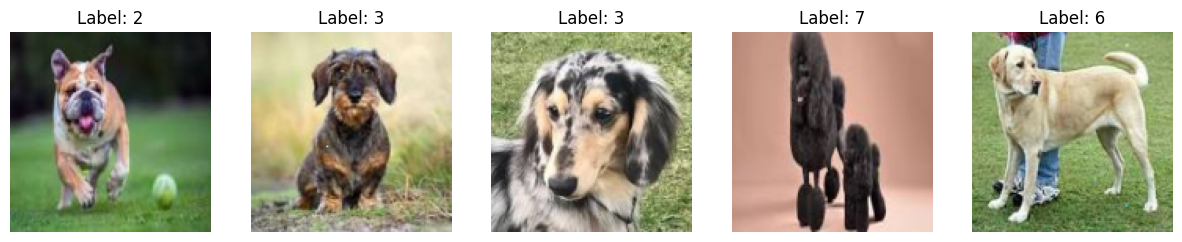

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

# Load the repaired images
repaired_images = torch.load('repaired_images.pt')

# Number of images to display
num_images_to_display = 5

# Randomly select images and labels
random_indices = random.sample(range(len(repaired_images)), num_images_to_display)

# Set up the plot
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for ax, idx in zip(axes, random_indices):
    repaired_image, label = repaired_images[idx]
    
    # Remove the batch dimension
    repaired_image = repaired_image.squeeze(0)  # Shape from [1, C, H, W] to [C, H, W]
    repaired_image = repaired_image.permute(1, 2, 0)  # Change shape from [C, H, W] to [H, W, C]
    
    # Display the image and its label
    ax.imshow(repaired_image.cpu().numpy())
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # Hide axes ticks

plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00        96
           4       1.00      1.00      1.00        96
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        95
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00        89
           9       1.00      1.00      1.00       100

    accuracy                           1.00       967
   macro avg       1.00      1.00      1.00       967
weighted avg       1.00      1.00      1.00       967

Accuracy: 100.00%


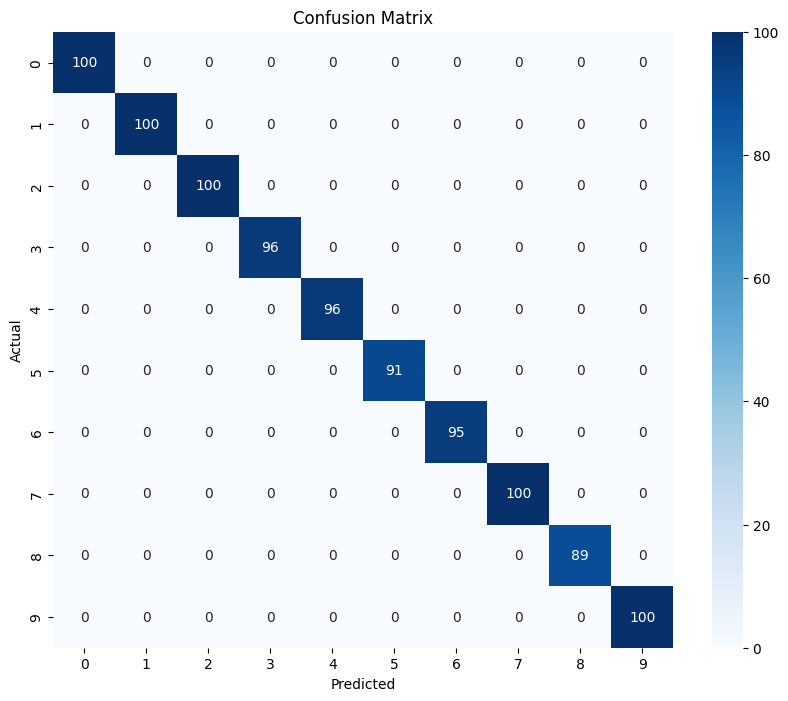

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the repaired images
repaired_images = torch.load('repaired_images.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier_model = SimpleCNN(num_classes).to(device)
classifier_model.load_state_dict(torch.load('classifier_cnn_model.pt'))
classifier_model.eval()

# Evaluate on repaired images
true_labels = []
predicted_labels = []

with torch.no_grad():
    for repaired_image, label in repaired_images:
        repaired_image = repaired_image.squeeze(0).to(device)  # Remove any unnecessary dimensions
        output = classifier_model(repaired_image)
        _, predicted = torch.max(output, 1)
        true_labels.append(label)  # Append label directly
        predicted_labels.append(predicted.item())

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Calculate accuracy
accuracy = sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
